# A parallel computing project - calculus of the Mandelbrot set
---

The problem proposed was the implementation of a parallel version of the Mandelbrot algorithm using the MPI library and two different kind of 2D distribution of the data:

* *Static Load Balancing (SLB)*: given an **MxN** matrix and **I** processes divided in a grid **PxQ** each process will have **M/P rows** and **N/Q columns**. If the matrix dimensions are not divisible by the number of the processes the reminders of the matrix division have to be calculated by the edge processes in the matrix grid (for simplicity)
* *Dynamic Load Balancing (DLB)*: given an **MxN** matrix and **I** processes divided in a grid **PxQ** each process will have **K\*M/P rows** and **K\*N/Q columns**. The load of the processes have do be balanced dynamically.

The possible grid configurations on wich we have to test the implementations are:

* 2x3
* 3x2
* 2x8
* 8x2
* 4x4

Instead the possible K values to test are:

* 0.25
* 0.50
* 0.75
* 1.0

The matrix will represent the image of the Mandelbrot set. Note that the *DLB* algorithm with *K=1.0* will be equal to the *SLB* algorithm.

The implementation have to be compared also with the serial version of the algorithm.


Here a Mandelbrot set image created as example:

<img src="./img/mandelbrot_set.png" />

The implementation of the algorithm has some parts in common that are:

* Mandelbrot function
* Log and print functions

We resume here the two implementations:

The **SLB** program divides the matrix and assigns a part of the final image for each processes available. The main process (*rank 0*) will calculate the first part of the subdivision after sending to each worker the data about the jobs and, after the calculus it will recollect all the results and it will build the final image.

The **DLB** approach is different; in this case the main process (*rank 0*) is only a manager and it will assign to the processes available their parts. Because of the dynamic behavior it uses a probe to inspect the incoming messages and assign the next job to the processes that have finished. After that is always the main process that recollect the remains pieces from the processes that are still busy, so it will wait all the remains worker.

To manage the communication each implementation has a **custom MPI type** that is used to send jobs and to call the exit of the programs. Each process manage his own buffers and is responsible for cleaning the environment.

Then we have some test results that can help us to choose the best approach to this problem.

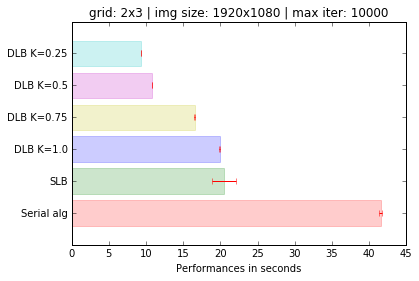

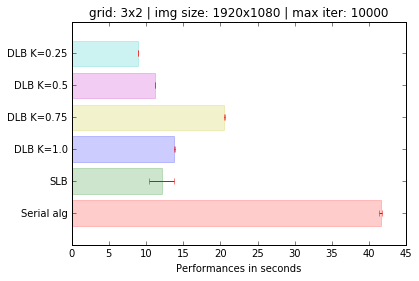

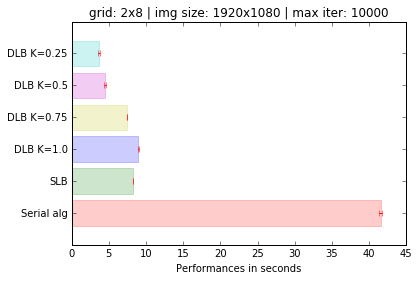

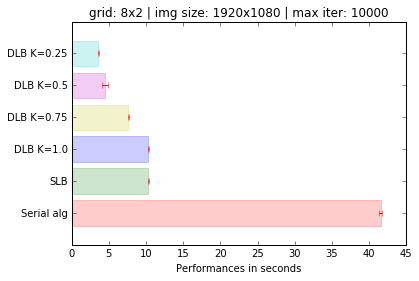

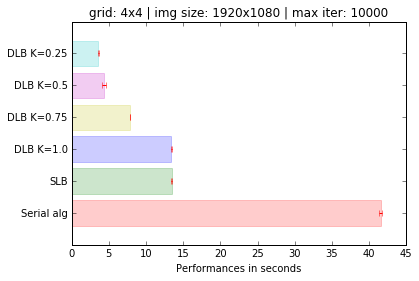

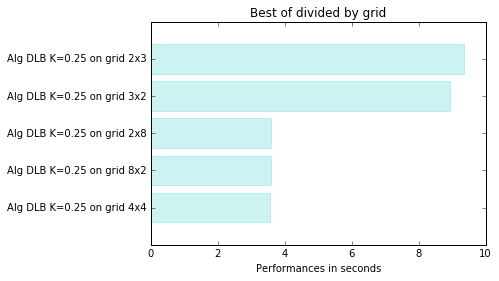

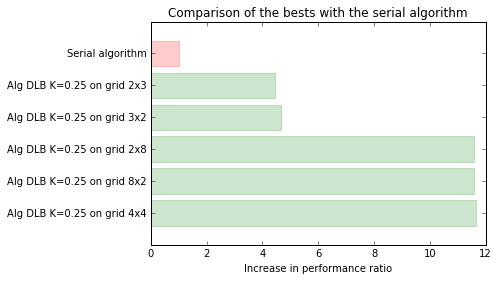

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Data type
Data = namedtuple('Data', ['name', 'values', 'color'])

# Serial algorithm result
serial_res = Data("Serial alg", [
                  41.473548, 41.49130, 41.554560, 41.548061, 41.500960, 41.624376], 'r')

# Results divided by grid
results = {
    '1:2x3': [
        serial_res,
        Data("SLB", [19.880025, 19.968172, 21.478465], 'g'),
        Data("DLB K=1.0", [19.882454, 19.877398, 19.901579], 'b'),
        Data("DLB K=0.75", [16.542082, 16.596994, 16.573060], 'y'),
        Data("DLB K=0.5", [10.804230, 10.806784, 10.805918], 'm'),
        Data("DLB K=0.25", [9.345953, 9.342480, 9.346098], 'c')
    ],
    '2:3x2': [
        serial_res,
        Data("SLB", [11.508417, 11.560420, 13.228415], 'g'),
        Data("DLB K=1.0", [13.833747, 13.787592, 13.816823], 'b'),
        Data("DLB K=0.75", [20.556518, 20.537614, 20.511860], 'y'),
        Data("DLB K=0.5", [11.179282, 11.170422, 11.170612], 'm'),
        Data("DLB K=0.25", [8.932684, 8.925099, 8.925993], 'c')
    ],
    '3:2x8': [
        serial_res,
        Data(
            "SLB", [8.246663, 8.271300, 8.284840, 8.239573, 8.219654, 8.263988], 'g'),
        Data("DLB K=1.0", [8.974964, 8.974731, 9.017683], 'b'),
        Data("DLB K=0.75", [7.440492, 7.462704, 7.463809], 'y'),
        Data("DLB K=0.5", [4.377791, 4.515337, 4.478852], 'm'),
        Data("DLB K=0.25", [3.742661, 3.587917, 3.743936], 'c')
    ],
    '4:8x2': [
        serial_res,
        Data(
            "SLB", [10.356765, 10.331735, 10.329354, 10.316771, 10.303473], 'g'),
        Data("DLB K=1.0", [10.281584, 10.331254, 10.250037], 'b'),
        Data("DLB K=0.75", [7.604316, 7.596230, 7.639483], 'y'),
        Data("DLB K=0.5", [4.660491, 4.656994, 4.281415], 'm'),
        Data("DLB K=0.25", [3.586759, 3.580526, 3.646517], 'c')
    ],
    '5:4x4': [
        serial_res,
        Data(
            "SLB", [13.475631, 13.488646, 13.475190, 13.425211, 13.427235], 'g'),
        Data("DLB K=1.0", [13.369775, 13.419909, 13.376456], 'b'),
        Data("DLB K=0.75", [7.819182, 7.816745, 7.817717], 'y'),
        Data("DLB K=0.5", [4.235432, 4.461016, 4.470079], 'm'),
        Data("DLB K=0.25", [3.620930, 3.564867, 3.616462], 'c')
    ],
}

# Show results
f_num = 0
for grid, data in sorted(results.items(), key=lambda elm: int(elm[0].split(":")[0])):
    plt.figure(f_num)

    y_pos = range(len(data))
    result_times = [np.mean(l.values) for l in data]
    errors = [max(l.values) - min(l.values) for l in data]

    bars = plt.barh(
        y_pos, result_times, xerr=errors, ecolor='r', align='center', alpha=0.2)
    plt.yticks(y_pos, [t.name for t in data])
    plt.xlabel('Performances in seconds')
    plt.title(
        'grid: {0} | img size: 1920x1080 | max iter: 10000'.format(grid.split(":")[1]))

    for num, t in enumerate(data):
        bars[num].set_color(t.color)
    f_num += 1

# Best results
plt.figure(f_num)

best_res_times = []
best_res_labels = []

for grid, data in sorted(results.items(), key=lambda elm: int(elm[0].split(":")[0])):
    best_res_times.append(min(data, key=lambda elm: elm.values))
    best_res_labels.append(grid)

y_pos = list(reversed(range(len(best_res_times))))

bars = plt.barh(y_pos, [min(l.values)
                        for l in best_res_times], align='center', alpha=0.2)
plt.yticks(y_pos, ["Alg {0} on grid {1}".format(best_res_times[
           num].name, elm.split(":")[1]) for num, elm in enumerate(best_res_labels)])
plt.xlabel('Performances in seconds')
plt.title("Best of divided by grid")

for num, t in enumerate(best_res_times):
    bars[num].set_color(t.color)

f_num += 1

# Best results difference with serial
plt.figure(f_num)
y_pos.append(len(y_pos))

bars = plt.barh(y_pos, [np.mean(serial_res.values) / min(l.values) for l in best_res_times] +
                [np.mean(serial_res.values) / np.mean(serial_res.values)], align='center', alpha=0.2)
plt.yticks(y_pos, ["Alg {0} on grid {1}".format(best_res_times[num].name, elm.split(
    ":")[1]) for num, elm in enumerate(best_res_labels)] + ["Serial algorithm"])
plt.xlabel('Increase in performance ratio')
plt.title("Comparison of the bests with the serial algorithm")

for num, t in enumerate(best_res_times):
    bars[num].set_color('g')

bars[-1].set_color('r')


In order to manage the project was created a simple script in python that takes care of the different sources and runs a simple routine composed by build the source and launch it in the queue. The script manages also the various streams and the killing of the processes if necessary.

The biggest problems found in this project are:

* Matrix subdivision and reconstruction with no decrementation of the performance
* Message communications, especially in DLB algorithm
* Choose the appropriate data types to manage the space occupied